In [29]:
using Plots, PlotThemes, LaTeXStrings
using OffsetArrays
using LinearAlgebra
using FFTW
using StatsBase
using Unitful
using Base: Fix1, Fix2
using Distributions
using ArbNumerics
using Trapz

pyplot()

theme(:mute)
default(;palette=:seaborn_deep6,fontfamily="serif")
j=im

imsizesq = (500,300)

(500, 300)

In [30]:
S = OffsetArray(sqrt(13/6).*[0, 0, 1+j, 0, 0, 0, -1-j, 0, 0, 0, 1+j, 0, 0, 0, -1-j, 0, 0, 0, -1-j, 0, 0, 0, 1+j, 0, 0, 0, 0,
0, 0, 0, -1-j, 0, 0, 0, -1-j, 0, 0, 0, 1+j, 0, 0, 0, 1+j, 0, 0, 0, 1+j, 0, 0, 0, 1+j, 0,0], -26:26)
L = OffsetArray([1.0, 1.0, -1.0, -1.0, 1.0, 1.0, -1.0, 1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1.0, 1.0, 1.0, -1.0, 1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 0,
1.0, -1.0, -1.0, 1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, 1.0, -1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0, 1.0, 1.0, 1.0] .|> Complex, -26:26) 

shift(x) = [i in 1:26 ? x[i] : (i in 38:63 ? x[i-64] : 0.0+im*0.0) for i in 0:63]

function shift(x, ifft_points)
    x_shift = vcat(x[0:26], zeros(ifft_points-53), x[-26:-1])
    return x_shift
end

function make_preamble(sym) 
    sym2 = sym[length(sym)-Int(length(sym)/2)+1:end]
    return vcat(sym2, sym, sym)
end

function freq_to_wave(x, ifft_points)
    return shift(x, ifft_points) |> ifft |> make_preamble
end

function to_db(snr)
    return 10*log10(snr)
end

N = 128
sym = freq_to_wave(S, N);

In [31]:
function estimate_noise(y, idx, N)
    y1 = y[idx:idx+N-1]
    return norm(y1)^2/(2*(N-1))
end
function estimate_noise2(y, idx, N)
    y1 = y[idx:idx+N-1]
    return norm(y1)^2/(2*N)
end

estimate_noise2 (generic function with 1 method)

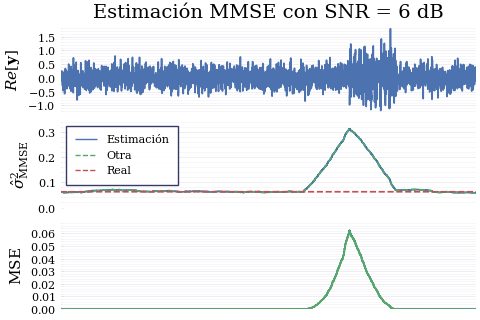

In [32]:
Ts = 8e-6
N = 3200
start_t1 = 700
start_t2 = 2000

σ = 0.25
d = Normal(0,σ)

snr = 4

A = σ*sqrt(2*length(sym)*snr)/norm(sym)

y = rand(d, N) .+ j.*rand(d, N)
f_err = 0.15e3
sym_ferr = A.*sym.*exp.(im*2*pi*f_err*Ts.* (1:length(sym)))
y[start_t2+1:start_t2+length(sym)] .+= sym_ferr

L = length(sym)

idxs = 1:length(y)-L

est_var = [estimate_noise(y, i, L) for i in idxs]
est_var2 = [estimate_noise2(y, i, L) for i in idxs]

true_var = idxs.*0 .+ σ^2

mse = (est_var.-true_var).^2
mse2 = (est_var2.-true_var).^2

idxs = 1:N-length(sym)

p1 = plot(real(y[idxs]), xticks=false, line=:steppost, ylabel=L"Re[\mathbf{y}]", xlabel="", label="", title="Estimación MMSE con SNR = $(Int(round(to_db(snr)))) dB", xlims=extrema(idxs))
p2 = plot(est_var, line=:steppost, ylabel=L"\hat{\sigma}_{\mathrm{MMSE}}^2", xlabel="", label="Estimación", xticks=[], ylims=(0, maximum(est_var)*1.1), xlims=extrema(idxs))
plot!(p2, est_var2, linestyle=:dash, label="Otra")
plot!(p2, true_var, linestyle=:dash, label="Real")
p3 = plot(mse, line=:steppost, ylabel=L"\mathrm{MSE}", xlabel="", xticks=[], label="", ylims=(0, maximum(mse)*1.1), xlims=extrema(idxs))
plot!(p3, mse2, line=:steppost, ylabel=L"\mathrm{MSE}", xlabel="", xticks=[], label="", ylims=(0, maximum(mse)*1.1), xlims=extrema(idxs))

plot(p1,p2,p3, layout=(3,1), size=(600,400).*0.8, legend=:topleft)

In [33]:
savefig("Avance 2/Images/mmse1.svg")

"/home/inox/Documents/IB/Tésis/Avance 2/Images/mmse1.svg"

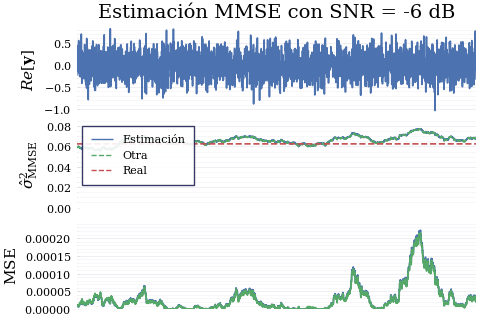

In [35]:
Ts = 8e-6
N = 3200
start_t1 = 700
start_t2 = 2000

σ = 0.25
d = Normal(0,σ)

snr = 1/4

A = σ*sqrt(2*length(sym)*snr)/norm(sym)

y = rand(d, N) .+ j.*rand(d, N)
f_err = 0.15e3
sym_ferr = A.*sym.*exp.(im*2*pi*f_err*Ts.* (1:length(sym)))
y[start_t2+1:start_t2+length(sym)] .+= sym_ferr

L = length(sym)

idxs = 1:length(y)-L

est_var = [estimate_noise(y, i, L) for i in idxs]
est_var2 = [estimate_noise2(y, i, L) for i in idxs]

true_var = idxs.*0 .+ σ^2

mse = (est_var.-true_var).^2
mse2 = (est_var2.-true_var).^2

idxs = 1:N-length(sym)

p1 = plot(real(y[idxs]), xticks=false, line=:steppost, ylabel=L"Re[\mathbf{y}]", xlabel="", label="", title="Estimación MMSE con SNR = $(Int(round(to_db(snr)))) dB", xlims=extrema(idxs))
p2 = plot(est_var, line=:steppost, ylabel=L"\hat{\sigma}_{\mathrm{MMSE}}^2", xlabel="", label="Estimación", xticks=[], ylims=(0, maximum(est_var)*1.1), xlims=extrema(idxs))
plot!(p2, est_var2, linestyle=:dash, label="Otra")
plot!(p2, true_var, linestyle=:dash, label="Real")
p3 = plot(mse, line=:steppost, ylabel=L"\mathrm{MSE}", xlabel="", xticks=[], label="", ylims=(0, maximum(mse)*1.1), xlims=extrema(idxs))
plot!(p3, mse2, line=:steppost, ylabel=L"\mathrm{MSE}", xlabel="", xticks=[], label="", ylims=(0, maximum(mse)*1.1), xlims=extrema(idxs))

plot(p1,p2,p3, layout=(3,1), size=(600,400).*0.8, legend=:topleft)

In [36]:
savefig("Avance 2/Images/mmse2.svg")

"/home/inox/Documents/IB/Tésis/Avance 2/Images/mmse2.svg"

In [37]:
function threshold(PFA, σ2, ref)
    return sqrt(-2*norm(ref)^2*σ2*log(PFA))
end

threshold (generic function with 1 method)

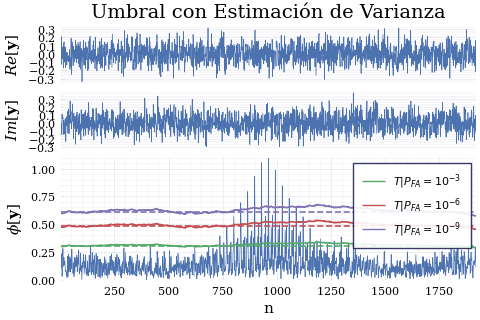

In [38]:
f_err = 0.000
N = length(sym)

σ = 0.1
d = Normal(0, σ)
sym_ferr = sym.*exp.(im*2*pi*f_err .* (1:N)) .+ rand(d, N) .+ j.*rand(d, N)

N = 5000
start_t = 3*length(sym)

y = vcat(zeros(start_t), sym, zeros(N-start_t-length(sym))) .+ rand(d, N) .+ j.*rand(d, N)
t = range(0u"μs", 16u"μs"/length(sym)*length(y), length=length(y))

function short_correlate(y, idx, ref)
    x1 = y[idx:idx+length(ref)-1]
    return x1'*ref
end

idxs = 1:start_t+3*length(sym)
est1 = vcat([short_correlate(y, i, sym) for i in idxs], zeros(length(sym)))
est_var = [estimate_noise(y, i, L) for i in idxs]

lims1 = (0, maximum(abs.(est1))).*1.2

theme(:mute)

plt = palette(:seaborn_deep6)

default(;palette=:seaborn_deep6,fontfamily="serif")

p11 = plot(real(y[idxs]), xticks=false, xlims=extrema(idxs), linewidth=0.5, ylabel=L"Re[\mathbf{y}]", xlabel="", title="Umbral con Estimación de Varianza")
p21 = plot(imag(y[idxs]), xticks=false, xlims=extrema(idxs), linewidth=0.5, ylabel=L"Im[\mathbf{y}]", xlabel="")
p1 = plot(p11,p21, layout=(2,1), legend=:false)
p2 = plot(abs.(est1[idxs]), xlims=extrema(idxs), ylabel=L"\phi[\mathbf{y}]", linewidth=0.5, xlabel="n", label="", ylims=(0,1.1))
PFA = 10e-3
T = [threshold(PFA, var, sym) for var in est_var]
plot!(p2, T, label=L"T|P_{FA}=10^{-3}", color=plt[2])
T = threshold(PFA, σ^2, sym)
plot!(p2, [1, maximum(idxs)], [T, T], linestyle=:dash, label="", color=plt[2])
PFA = 10e-6
T = [threshold(PFA, var, sym) for var in est_var]
plot!(p2, T, label=L"T|P_{FA}=10^{-6}", color=plt[3])
T = threshold(PFA, σ^2, sym)
plot!(p2, [1, maximum(idxs)], [T, T], linestyle=:dash, label="", color=plt[3])
PFA = 10e-9
T = [threshold(PFA, var, sym) for var in est_var]
plot!(p2, T, label=L"T|P_{FA}=10^{-9}", color=plt[4])
T = threshold(PFA, σ^2, sym)
plot!(p2, [1, maximum(idxs)], [T, T], linestyle=:dash, label="", color=plt[4])


plot(p1, p2, layout=(2,1), size=(600,400).*0.8)

In [39]:
savefig("Avance 2/Images/umbral_2.svg")

"/home/inox/Documents/IB/Tésis/Avance 2/Images/umbral_2.svg"

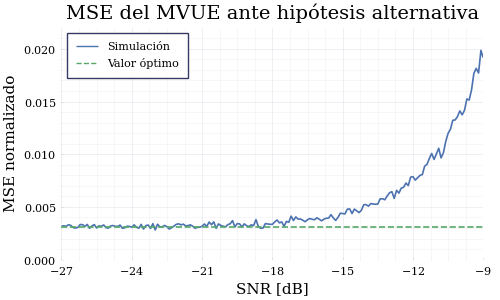

In [40]:
function calc_mse_normalized(snr, sym, σ)
    Nrealz = 1000
    A = σ*sqrt(2*length(sym)*snr)/norm(sym)
    sse = 0
    for i in 1:Nrealz
        d = Normal(0,σ)
        y = rand(d, length(sym)) .+ j.*rand(d, length(sym)) .+ A.*sym
        est = norm(y)^2/(2*length(y))
        sse += (σ^2-est)^2
    end
    return sse/Nrealz/(σ^2)^2
end

snrs = 10 .^((-27:0.1:-9)./10)

sigma = 100
snrsdb = 10 .* log10.(snrs)
p1=plot(snrsdb, [calc_mse_normalized(snr, sym, sigma) for snr in snrs], ylabel="MSE normalizado", xlabel="SNR [dB]", label="Simulación", legend=:topleft, title="MSE del MVUE ante hipótesis alternativa", size=imsizesq, xlims=extrema(snrsdb))
plot!(p1, [snrsdb[1], snrsdb[end]], [1/length(sym), 1/length(sym)], label = "Valor óptimo", linestyle=:dash, ylims=[0,0.022])


In [41]:
savefig("Tésis/ibtesis/figs/estimator_mse_snr.pdf")

"/home/inox/Documents/IB/Tésis/Tésis/ibtesis/figs/estimator_mse_snr.pdf"

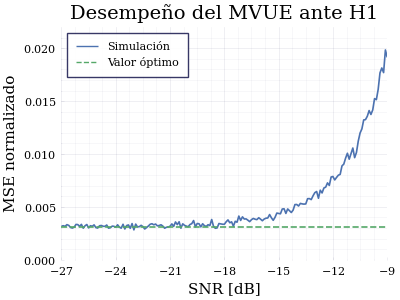

In [42]:
imsizeP = (400,300)
plot(p1, size=imsizeP, title="Desempeño del MVUE ante H1")

In [43]:
savefig("Defensa/Images/estimator_mse_snr.pdf")

"/home/inox/Documents/IB/Tésis/Defensa/Images/estimator_mse_snr.pdf"

In [45]:
function calc_mse(var, sym)
    Nrealz = 100
    square_errors = []
    for i in 1:Nrealz
        d = Normal(0,sqrt(var))
        y = rand(d, length(sym)) .+ j.*rand(d, length(sym))
        est = norm(y)^2/(2*length(y))
        push!(square_errors,(var-est)^2)
    end
    return mean(square_errors)
end
expected_mse(var, sym) = var^2/(length(sym))

expected_mse (generic function with 1 method)

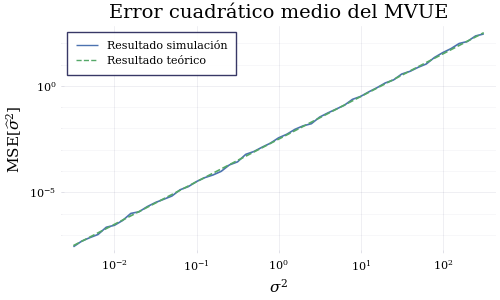

In [46]:
vars = 10 .^(-2.5:0.1:2.5)

plot(vars, [calc_mse(var, sym) for var in vars], ylabel=L"\mathrm{MSE}\left[\widehat{\sigma}^2\right]", xlabel=L"\sigma^2", label="Resultado simulación", title="Error cuadrático medio del MVUE", xaxis=:log10, yaxis=:log, size=imsizesq)
plot!(vars, [expected_mse(var, sym) for var in vars], linestyle=:dash, label="Resultado teórico", legend=:topleft)

In [47]:
savefig("Tésis/ibtesis/figs/estimator_mse.pdf")

"/home/inox/Documents/IB/Tésis/Tésis/ibtesis/figs/estimator_mse.pdf"

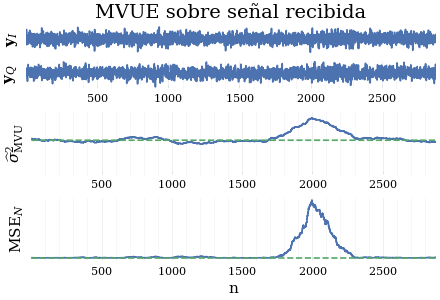

In [48]:
Ts = 8e-6
N = 3200
start_t1 = 700
start_t2 = 2000

σ = 1.0
d = Normal(0,σ)

snr = 1/2

A = σ*sqrt(2*length(sym)*snr)/norm(sym)

y = rand(d, N) .+ j.*rand(d, N)
f_err = 0.15e3
sym_ferr = A.*sym.*exp.(im*2*pi*f_err*Ts.* (1:length(sym)))
y[start_t2+1:start_t2+length(sym)] .+= sym_ferr

L = length(sym)

idxs = 1:length(y)-L

function estimate_noise(y, idx, N)
    y1 = y[idx:idx+N-1]
    return norm(y1)^2/(2*N)
end


est_var = [estimate_noise(y, i, L) for i in idxs]

true_var = idxs.*0 .+ σ^2

mse = ((est_var.-true_var).^2)./σ^4

idxs = 1:N-length(sym)

p11 = plot(real(y[idxs]), line=:steppost, ylabel=L"\mathbf{y}_I", xlabel="", label="", title="MVUE sobre señal recibida", xlims=extrema(idxs), xticks=false)
p12 = plot(imag(y[idxs]), line=:steppost, ylabel=L"\mathbf{y}_Q", xlabel="", label="", xlims=extrema(idxs))
p1=plot(p11,p12,layout=(2,1))
p2 = plot(est_var, line=:steppost, ylabel=L"\widehat{\sigma}_{\mathrm{MVU}}^2", xlabel="", label="Estimación",  ylims=(0, maximum(est_var)*1.1), xlims=extrema(idxs))
plot!(p2, true_var, linestyle=:dash, label="Real")
p3 = plot(mse, line=:steppost, ylabel=L"\mathrm{MSE}_N", xlabel="n", label="", xlims=extrema(idxs))
plot!(p3, [extrema(idxs)...], [1,1]./length(sym), linestyle=:dash, label="Real")

plot(p1,p2,p3, layout=(3,1), size=(imsizeP[1].*1.1, imsizeP[2]), legend=false, yticks=false)

In [49]:
savefig("Defensa/Images/estimator_trama.pdf")

"/home/inox/Documents/IB/Tésis/Defensa/Images/estimator_trama.pdf"

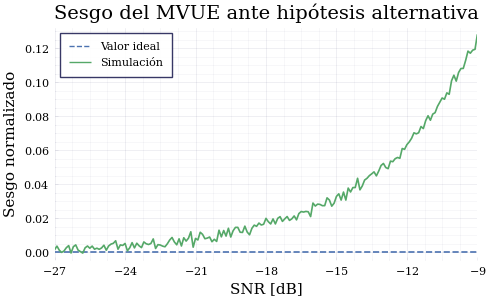

In [50]:

function calc_bias_normalized(snr, sym, σ)
    Nrealz = 1000
    A = σ*sqrt(2*length(sym)*snr)/norm(sym)
    sse = 0
    for i in 1:Nrealz
        d = Normal(0,σ)
        y = rand(d, length(sym)) .+ j.*rand(d, length(sym)) .+ A.*sym
        est = norm(y)^2/(2*length(y))
        sse += est-σ^2
    end
    return sse/Nrealz/(σ^2)
end


snrs = 10 .^((-27:0.1:-9)./10)

sigma = 100
snrsdb = 10 .* log10.(snrs)
p1 = plot([snrsdb[1], snrsdb[end]], [0, 0], label = "Valor ideal", linestyle=:dash)
plot!(p1,snrsdb, [calc_bias_normalized(snr, sym, sigma) for snr in snrs], ylabel="Sesgo normalizado", xlabel="SNR [dB]", label="Simulación", legend=:topleft, title="Sesgo del MVUE ante hipótesis alternativa", size=imsizesq, xlims=extrema(snrsdb))

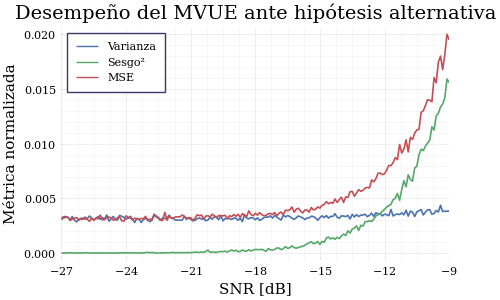

In [51]:

function calc_variance_normalized(snr, sym, σ)
    Nrealz = 1000
    A = σ*sqrt(2*length(sym)*snr)/norm(sym)
    mse = 0
    bias= 0
    for i in 1:Nrealz
        d = Normal(0,σ)
        y = rand(d, length(sym)) .+ j.*rand(d, length(sym)) .+ A.*sym
        est = norm(y)^2/(2*length(y))
        bias+= est-σ^2
        mse += (σ^2-est)^2
    end
    return (mse/Nrealz - (bias/Nrealz)^2)/(σ^2)^2
end



snrs = 10 .^((-27:0.1:-9)./10)

sigma = 100
snrsdb = 10 .* log10.(snrs)
p1 = plot()
plot!(p1,snrsdb, [calc_variance_normalized(snr, sym, sigma) for snr in snrs], ylabel="Métrica normalizada", xlabel="SNR [dB]", legend=:topleft, title="Desempeño del MVUE ante hipótesis alternativa", size=imsizesq, xlims=extrema(snrsdb), label="Varianza")
plot!(p1,snrsdb, [calc_bias_normalized(snr, sym, sigma) for snr in snrs].^2, label="Sesgo²")
plot!(p1,snrsdb, [calc_mse_normalized(snr, sym, sigma) for snr in snrs], label="MSE")

In [52]:
savefig("Tésis/ibtesis/figs/estimator_mse_snr.pdf")

"/home/inox/Documents/IB/Tésis/Tésis/ibtesis/figs/estimator_mse_snr.pdf"

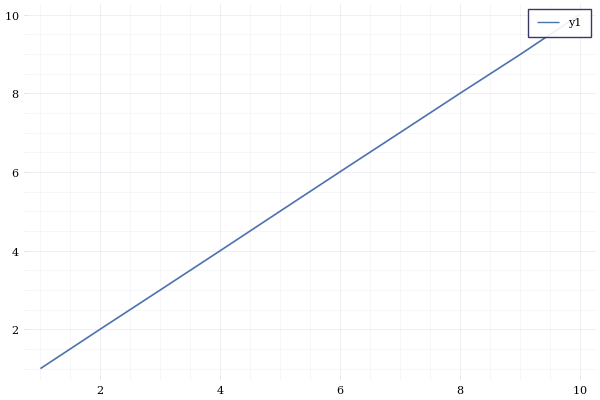

In [53]:
function find_K(var)
    k = zeros(5,5) .|> Complex
    nrealz = 100000
    s = sqrt(var/2)
    for i in 1:nrealz
        x = rand(Normal(0,s), 5) .+ j.*rand(Normal(0,s), 5)
        k .+= x*x'
    end
    return k./nrealz
end

function avgdiag(var) 
    return find_K(var) |> diag .|> real |> mean
end

plot(1:10, avgdiag.(1:10))

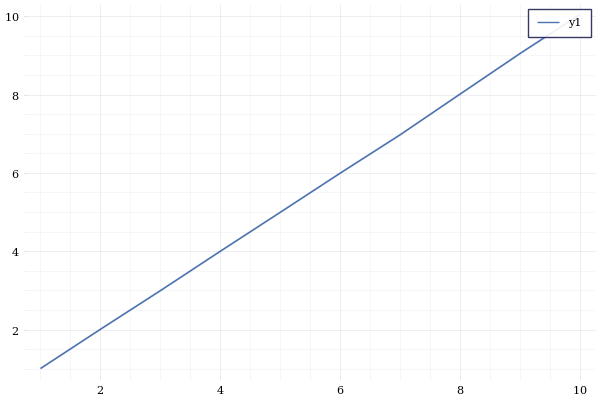

In [54]:
function find_mean_sq(var)
    nrealz = 100000
    s = sqrt(var/2)
    x = rand(Normal(0,s), nrealz) .+ j.*rand(Normal(0,s), nrealz)
    return mean(abs.(x).^2)
end

plot(1:10, find_mean_sq.(1:10))

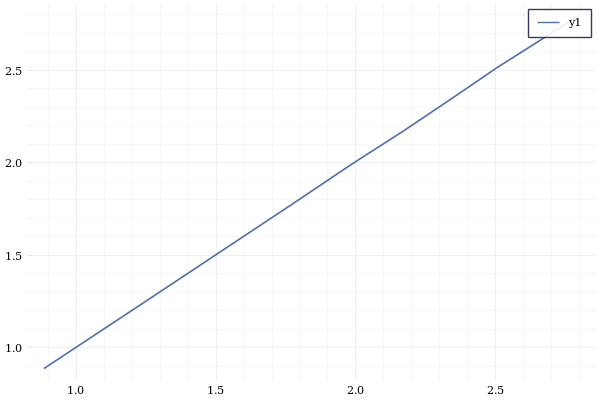

In [55]:
function find_mean(var)
    nrealz = 100000
    s = sqrt(var/2)
    x = rand(Normal(0,s), nrealz) .+ j.*rand(Normal(0,s), nrealz)
    return mean(abs.(x))
end

function expected_mean(var)
    return sqrt(pi*var/4)
end

plot(expected_mean.(1:10), find_mean.(1:10))